In [1]:
from os import getcwd
from os import path
from copy import deepcopy

import numpy as np
import optuna
from optuna.trial import TrialState
import pickle
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from src.data.load_dataset import load_mnist
from src.models.networks import V1_mnist_RFNet, classical_RFNet
from src.models.utils import train, test 

In [ ]:
data_dir = path.abspath(path.join(getcwd(), '../../'))

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size = 256
epochs = 10
log_interval = 10

In [3]:
V1_RFNet = V1_mnist_RFNet(100, 5.0, 2.0, center=None).to(device)

In [9]:
def V1_RFNet_objective(trial):
    
    # load the data
    train_loader, val_loader, _ = load_mnist(train_batch_size=batch_size, train_percentage=0.2)
    
    # load the model
    s = trial.suggest_uniform("size", 0.01,  10)
    f = trial.suggest_uniform("frequency", 0.01, 10)
    model = V1_mnist_RFNet(100, s, f, center=None).to(device)
    
    # generate optimizers, learning rate, and the loss function
    lr = 0.0031485838088746586
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    loss_fn = F.cross_entropy

#     lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
#     optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
#     loss_fn = F.cross_entropy_loss

    
    # train and validate
    for epoch in range(epochs + 1):
        _ = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
        val_accuracy = test(model, device, val_loader, loss_fn, verbose=False)
        
        trial.report(val_accuracy, epoch)
    
        # prune if unpromising trial
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()
    
    return val_accuracy

In [10]:
# create a hyperparameter study
v1_study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction='maximize')
v1_study.optimize(V1_RFNet_objective, n_trials=50)

pruned_trials = v1_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = v1_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(v1_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = v1_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-16 12:54:22,920] A new study created in memory with name: no-name-b3af07ff-c521-4509-be84-2ad220d9d61f
[I 2021-07-16 12:55:50,211] Trial 0 finished with value: 88.84166666666667 and parameters: {'size': 2.4718885529366545, 'frequency': 3.9976542849210426}. Best is trial 0 with value: 88.84166666666667.
[I 2021-07-16 12:57:19,006] Trial 1 finished with value: 88.43958333333333 and parameters: {'size': 6.737415072947277, 'frequency': 3.1447814599276245}. Best is trial 0 with value: 88.84166666666667.
[I 2021-07-16 12:58:48,923] Trial 2 finished with value: 90.90416666666667 and parameters: {'size': 5.3403768810194645, 'frequency': 1.9655706988242505}. Best is trial 2 with value: 90.90416666666667.
[I 2021-07-16 13:00:17,208] Trial 3 finished with value: 85.06875 and parameters: {'size': 9.122211311793622, 'frequency': 4.405116022622264}. Best is trial 2 with value: 90.90416666666667.
[I 2021-07-16 13:01:45,703] Trial 4 finished with value: 84.79166666666667 and parameters: {'s

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  90.90416666666667
  Params: 
    size: 5.3403768810194645
    frequency: 1.9655706988242505


In [11]:
# save the parameter study
import joblib
joblib.dump(v1_study, data_dir + '/models/results/mnist_clf/mnist_param_study.pkl')

['/home/bpandey/random_features/models/results/mnist_clf/mnist_param_study.pkl']

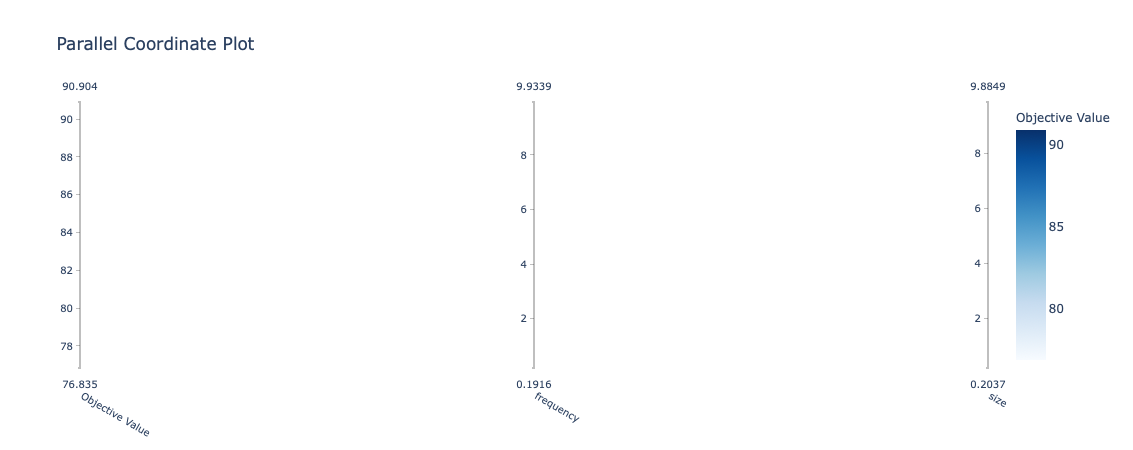

In [13]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import plotly.express as px
fig = optuna.visualization.plot_parallel_coordinate(v1_study)
fig.show()

In [14]:
# train the model using the most optimal hyperparams
hidden_size = 1000
s, f, c = 5.34, 1.965, None
lr = 0.0031485838088746586
# lr = 0.005250366870356006 # multimargin loss
# lr = 0.014717452942551123
num_epochs = 5
log_interval = 100

# define the model, optimize, loss
model = V1_mnist_RFNet(hidden_size, s, f, c).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.multi_margin_loss

# load data
train_batch_size, train_percentage = 256, 0.999
train_loader, val_loader, test_loader = load_mnist(train_batch_size, train_percentage)

for epoch in range(num_epochs):
    _ = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
test_accuracy = test(model, device, test_loader, loss_fn, verbose=True)

Train_epoch: 0 [0/59940 (0%)]	Loss: 20.410599
Train_epoch: 0 [25600/59940 (43%)]	Loss: 0.458296
Train_epoch: 0 [51200/59940 (85%)]	Loss: 0.206055
Train_epoch: 1 [0/59940 (0%)]	Loss: 0.140204
Train_epoch: 1 [25600/59940 (43%)]	Loss: 0.154340
Train_epoch: 1 [51200/59940 (85%)]	Loss: 0.132329
Train_epoch: 2 [0/59940 (0%)]	Loss: 0.069124
Train_epoch: 2 [25600/59940 (43%)]	Loss: 0.070409
Train_epoch: 2 [51200/59940 (85%)]	Loss: 0.148159
Train_epoch: 3 [0/59940 (0%)]	Loss: 0.148917
Train_epoch: 3 [25600/59940 (43%)]	Loss: 0.484362
Train_epoch: 3 [51200/59940 (85%)]	Loss: 0.234719
Train_epoch: 4 [0/59940 (0%)]	Loss: 0.149088
Train_epoch: 4 [25600/59940 (43%)]	Loss: 0.097333
Train_epoch: 4 [51200/59940 (85%)]	Loss: 0.367517

Test set: Average loss: 0.186231. Accuracy: 9552/10000 (95.52%)



### classical network

In [ ]:
inp_size = (1, 28, 28)
hidden_size = 500
def classical_RFNet_objective(trial):
    
    # load the data
    train_loader, val_loader, _ = load_mnist(train_batch_size=batch_size, train_percentage=0.2)
    
    # load the model
    model = classical_RFNet(inp_size, hidden_size).to(device)
    
    # generate optimizers and the learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # train and validate
    for epoch in range(epochs + 1):
        _ = train(log_interval, device, model, train_loader, optimizer, epoch, verbose=False)
        val_accuracy = test(model, device, val_loader, verbose=False)
        
        trial.report(val_accuracy, epoch)
    
        # prune if unpromising trial
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return val_accuracy

In [ ]:
# create a hyperparameter study
classical_study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
classical_study.optimize(classical_RFNet_objective, n_trials=50)

pruned_trials = classical_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = classical_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(classical_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = classical_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# train the model using the most optimal hyperparams
inp_size = (1, 28, 28)
hidden_size = 1000
lr = 0.01922083004518646
num_epochs = 5
log_interval = 100

# define the model
model = classical_RFNet(inp_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.cross_entropy

# load data
train_batch_size, train_percentage = 256, 0.999
train_loader, val_loader, test_loader = load_mnist(train_batch_size, train_percentage)

for epoch in range(num_epochs):
    _ = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=True)
test_accuracy = test(model, device, test_loader, verbose=True)